In [1]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.datasets import mnist
import tensorflow.keras

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [0]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

In [0]:
def sampling(args):
    
    z_mean, _log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim), mean = 0.0, stddev = 1.0)
    
    return z_mean + K.exp(z_log_var) * epsilon

In [4]:
input_img = Input(shape = img_shape)

x = input_img
x = Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
x = Conv2D(64, 3, padding = 'same', activation = 'relu', strides = (2, 2))(x)
x = Conv2D(64, 3, padding = 'same', activation = 'relu')(x)
x = Conv2D(64, 3, padding = 'same', activation = 'relu')(x)

shape_before_flatening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation = 'relu')(x)

z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

z = Lambda(sampling)([z_mean, z_log_var])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
decoder_input = Input(K.int_shape(z)[1:])

x = Dense(np.prod(shape_before_flatening[1:]), activation = 'relu')(decoder_input)
x = Reshape(shape_before_flatening[1:])(x)

x = Conv2DTranspose(32, 3, padding = 'same', activation = 'relu', strides = (2, 2))(x)

x = Conv2D(1, 3, padding = 'same', activation = 'sigmoid')(x)

decoder = Model(decoder_input, x)

In [0]:
z_decoded = decoder(z)

In [0]:
class CustomVariationalLayer(tensorflow.keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)

        return x

In [8]:
y = CustomVariationalLayer()([input_img, z_decoded])

vae = Model(input_img, y)
vae.compile(optimizer = 'rmsprop', loss = None)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [0]:
(X_train, _), (x_test, y_test) = mnist.load_data()
X_train = X_train/255
X_train = X_train.reshape(X_train.shape + (1,))
x_test = x_test/255
x_test = x_test.reshape(x_test.shape + (1,))

In [10]:
vae.fit(x = X_train, y = None, shuffle = True, epochs = 20, batch_size = batch_size, validation_data = (x_test, None))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 23s 380us/sample - loss: 0.2136 - val_loss: 0.1955
Epoch 2/20
60000/60000 [==============================] - 21s 345us/sample - loss: 0.1931 - val_loss: 0.1894
Epoch 3/20
60000/60000 [==============================] - 21s 345us/sample - loss: 0.1885 - val_loss: 0.1898
Epoch 4/20
60000/60000 [==============================] - 21s 347us/sample - loss: 0.1859 - val_loss: 0.1849
Epoch 5/20
60000/60000 [==============================] - 21s 346us/sample - loss: 0.1841 - val_loss: 0.1836
Epoch 6/20
60000/60000 [==============================] - 21s 356us/sample - loss: 0.1828 - val_loss: 0.1831
Epoch 7/20
60000/60000 [==============================] - 21s 344us/sample - loss: 0.1817 - val_loss: 0.1813
Epoch 8/20
60000/60000 [==============================] - 21s 343us/sample - loss: 0.1809 - v

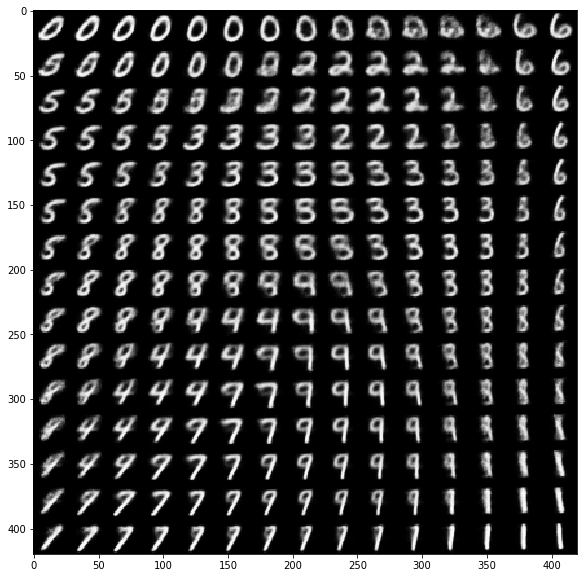

In [11]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()